In [22]:
from PIL import Image

# Load the original image
PATH = "/Users/mitchellkrieger/Downloads/drive-download-20241206T052204Z-001"
original_image1 = Image.open(PATH + "/img_0_0.png").convert("RGB")
width, height = original_image1.size

In [3]:
import numpy as np

# Convert image to numpy
image_np = np.array(original_image1)

mask = np.zeros((height, width))
mask[:height // 2, :width // 2] = 1
mask[height // 2:, width // 2:] = 1

# mask_np is a boolean array: True where the pixel is black, False otherwise
# Convert boolean mask to image: True -> white, False -> black
mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("RGB")

In [4]:
import torch
from diffusers import StableDiffusionInpaintPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the Stable Diffusion inpainting pipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

/Users/mitchellkrieger/Documents/GitHub/CS5787-Final/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:  57%|█████▋    | 4/7 [00:00<00:00, 14.81it/s]An error occurred while trying to fetch /Users/mitchellkrieger/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/mitchellkrieger/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  3.35it/s]An error occurred while trying to fetch /Users/mitc

In [5]:
result = pipe(
    prompt="scenery",
    image=original_image1,
    mask_image=mask_image,
    num_inference_steps=50,
    guidance_scale=7.5
)

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


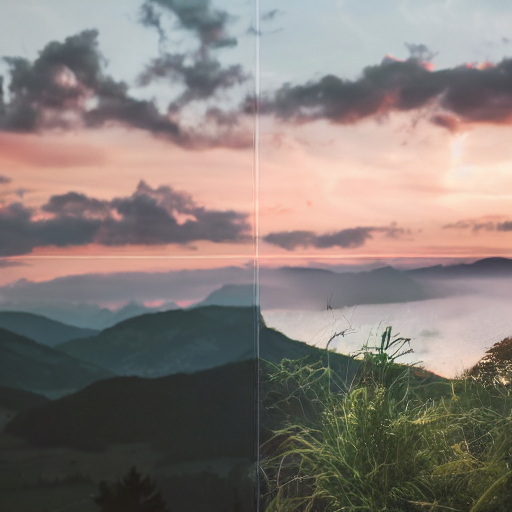

In [6]:
result.images[0]

In [ ]:
result.images[0]

In [ ]:
result.images[0]

In [7]:
original_image1

In [13]:
original_image2 = Image.open(PATH + "/img_0_1.png").convert("RGB")

In [ ]:


result = pipe(
    prompt="scenery",
    image=original_image2,
    mask_image=mask_image,
    num_inference_steps=50,
    guidance_scale=7.5
)

result.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

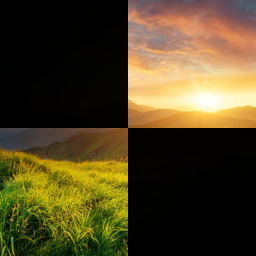

In [ ]:
original_image2

In [14]:
from PIL import Image
import numpy as np

# Assuming original_image1 and original_image2 are already loaded as PIL Images

def combine_images(original_image1, original_image2):
    """Combines the left half of image1 with the right half of image2."""

    width1, height1 = original_image1.size
    width2, height2 = original_image2.size

    # Ensure both images have the same height
    if height1 != height2:
        raise ValueError("Images must have the same height")

    # Calculate the midpoint of the width
    midpoint = width1 // 2

    # Crop the left side of image1
    left_half = original_image1.crop((0, 0, midpoint, height1))

    # Crop the right side of image2
    right_half = original_image2.crop((width2 - midpoint, 0, width2, height2))

    # Create a new image with the combined halves
    combined_image = Image.new("RGB", (width1, height1))
    combined_image.paste(left_half, (0, 0))
    combined_image.paste(right_half, (midpoint, 0))

    return combined_image
img1 = Image.open(PATH + "/img_0_1.png").convert("RGB")
img2 = Image.open(PATH + "/img_0_2.png").convert("RGB")
# Example usage (assuming original_image1 and original_image2 are defined)
combined_image = combine_images(img1, img2)
combined_image.save("combined_image.png")  # Save the combined image

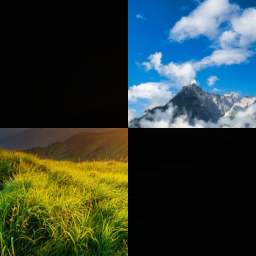

In [15]:
combined_image

In [16]:
comb2 = combine_images(original_image1, original_image2)

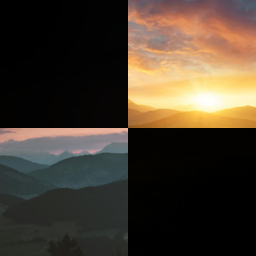

In [17]:
comb2


100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


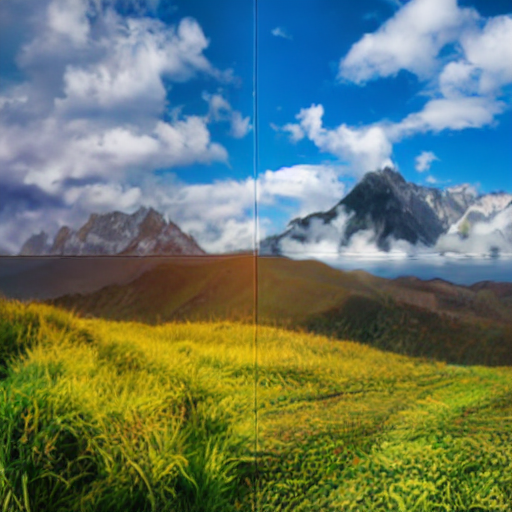

In [21]:
loaded_img = Image.open('./combined_image.png').convert("RGB")
result = pipe(
    prompt="scenery",
    image=loaded_img,
    mask_image=mask_image,
    num_inference_steps=50,
    guidance_scale=7.5
)

result.images[0]

In [30]:
from torchvision import transforms
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

In [23]:
def crop_image(img, crop_ratio=.4):
    assert 0 < crop_ratio < 1
    _, H, W = img.shape
    H_crop = int(H * crop_ratio)
    W_crop = int(W * crop_ratio)

    left_bottom = img[:, H - H_crop :, :W_crop]
    right_top = img[:, :H_crop, W - W_crop :]

    # input: left bottom and right top
    input_img = torch.zeros_like(img)
    input_img[:, H - H_crop :, :W_crop] = left_bottom
    input_img[:, :H_crop, W - W_crop :] = right_top

    # target: right bottom and left top
    target_img = img.clone()
    target_img[:, H - H_crop :, :W_crop] = 0
    target_img[:, :H_crop, W - W_crop :] = 0

    mask = torch.ones_like(img)
    mask[:, H - H_crop :, :W_crop] = 0
    mask[:, :H_crop, W - W_crop :] = 0
    return input_img, target_img, mask

In [31]:
img = Image.open("/Users/mitchellkrieger/Downloads/data-scenery-small-test/original1.jpg")

In [36]:
img, target, mask = crop_image(transform(img))

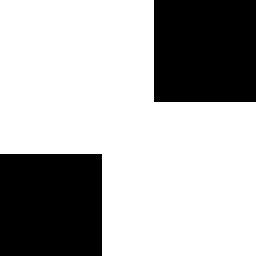

In [49]:
img_input = transforms.ToPILImage()(img *.5 +.5)
mask = transforms.ToPILImage()(mask)
mask

100%|██████████| 50/50 [01:25<00:00,  1.72s/it]


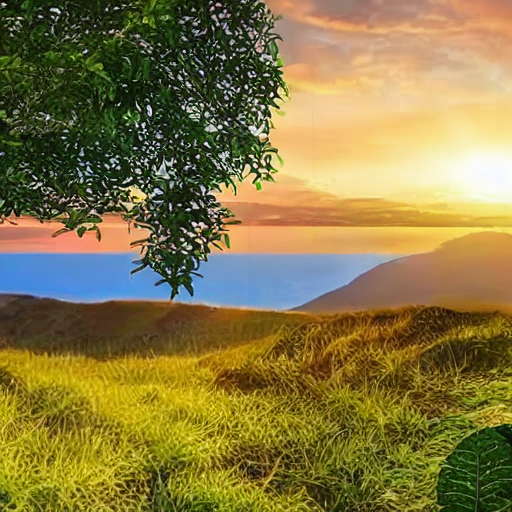

In [50]:
result = pipe(
    prompt="scenery",
    image=img_input,
    mask_image=mask,
    num_inference_steps=50,
    guidance_scale=7.5
)

result.images[0]

100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


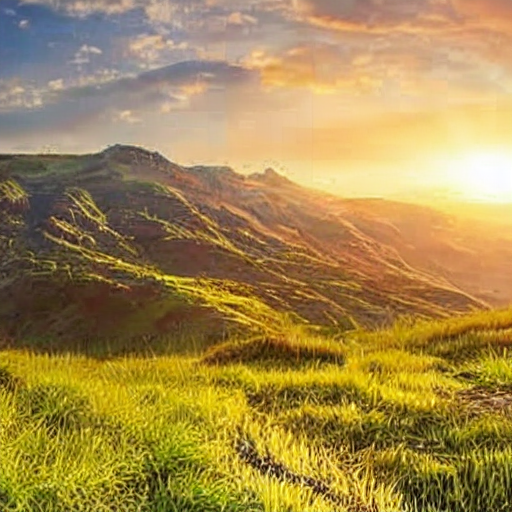

In [51]:
result = pipe(
    prompt="scenery",
    image=img_input,
    mask_image=mask,
    num_inference_steps=50,
    guidance_scale=7.5
)

result.images[0]

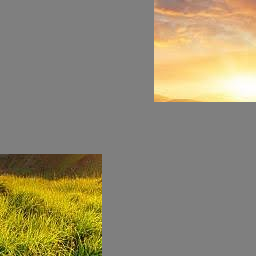

In [46]:
img_input

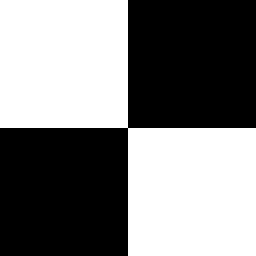

In [47]:
mask_image

In [48]:
mask

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])